In [98]:
import numpy as np
import cv2
import glob
import time
from random import randint
from sklearn.svm import LinearSVC
from skimage.measure import label
from skimage.measure import regionprops
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# some commonly used functions
def read_image(image_path):
    """
        read the image in the given path
        as cv2.imread returns BGR images, apply transformation to expected RGB
    """
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

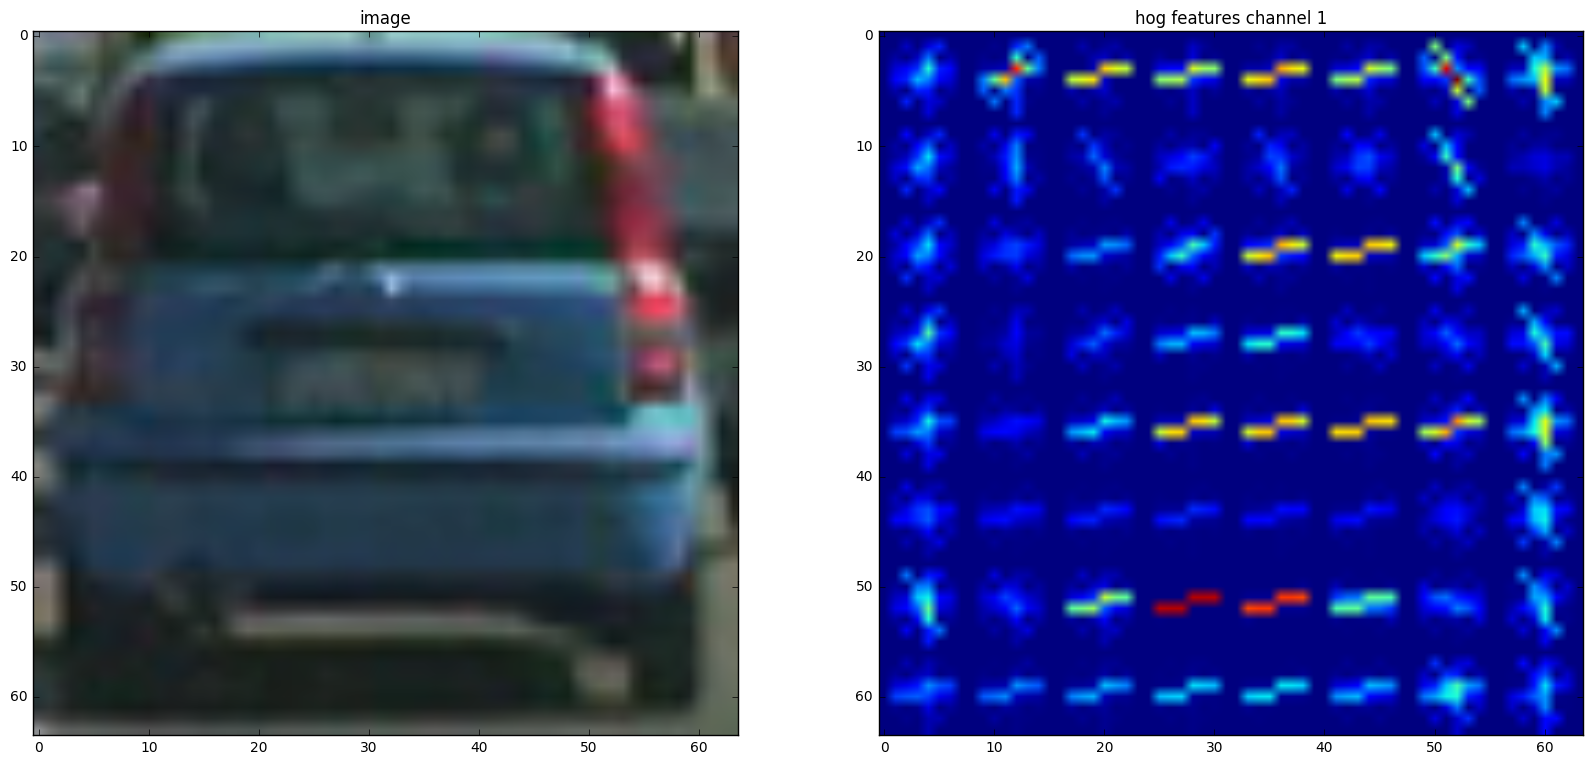

In [100]:
# show case hog features
from feature_extraction import hog_features

image = read_image('./training/vehicles/GTI_MiddleClose/image0240.png')
_, feature_image = hog_features(image, visualize=True)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,10))
ax0.set_title('image')
ax0.imshow(image)
ax1.set_title('hog features channel 1')
ax1.imshow(feature_image)


In [101]:
# Read in car and non-car images
car_images_path = './training/vehicles/GTI*/*'
not_car_images_path = './training/non-vehicles/GTI*/*'
cars = [read_image(x) for x in glob.glob(car_images_path)]
not_cars = [read_image(x) for x in glob.glob(not_car_images_path)]
print('read: ', 'car ', len(cars), ' images and ', len(not_cars), ' non car images')

read:  car  8792  images and  9666  non car images


In [102]:
# create trainings and test set
from pipeline import create_train_test_set

X_train, X_test, y_train, y_test, scaler = create_train_test_set(cars, not_cars)

In [103]:
# train a LinearSVC on the test data
from sklearn.externals import joblib

lsvc = LinearSVC(class_weight='balanced')

t=time.time()
lsvc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train LinearSVC')

# Check the score of the classifier
print('Test Accuracy of LinearSVC = ', round(lsvc.score(X_test, y_test), 4))

# Check the prediction time for some samples
t=time.time()
n_predict = 10
print('LinearSVC predicts: ', lsvc.predict(X_test[0:n_predict]))
print('For these ', n_predict, ' labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,' labels')
joblib.dump(lsvc, 'lsvc.pkl')


15.5 seconds to train LinearSVC
Test Accuracy of LinearSVC =  0.9837
LinearSVC predicts:  [ 0.  1.  0.  1.  1.  1.  1.  1.  1.  0.]
For these  10  labels:  [ 0.  1.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00261 Seconds to predict 10  labels


['lsvc.pkl']

In [109]:
from window_detection import create_windows

window_definition = [
    ((64, 64),  [350, 500]),
    ((96, 96),  [350, 550]),
    ((128, 128),[400, 620]),
    ((192, 192),[450, 720]),
]
image_size = (720, 1280)

# create the windows to used below in video processing
windows = create_windows(window_definition, image_size)
window_list = np.concatenate(windows)

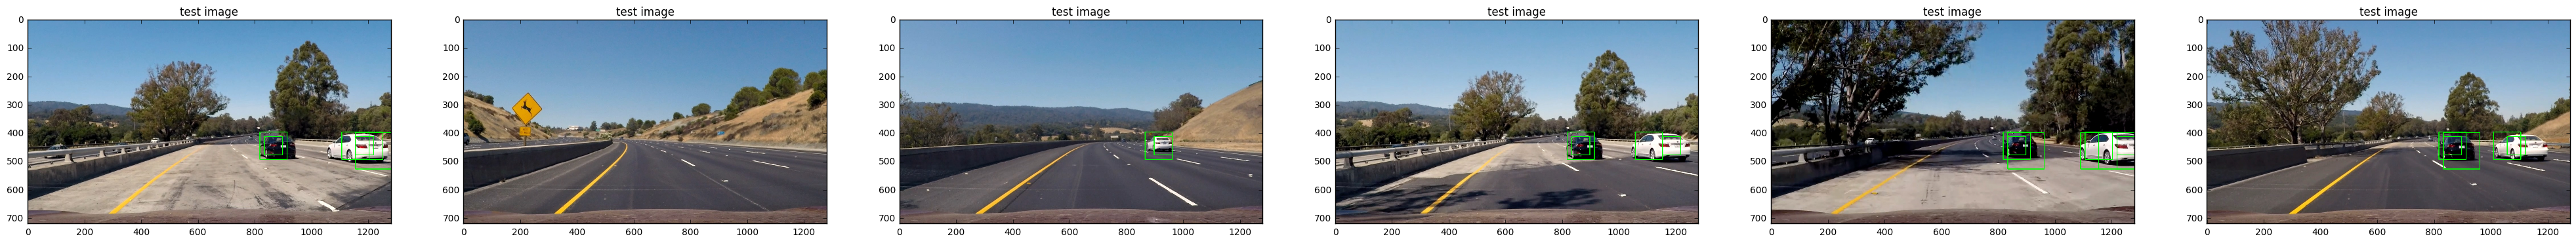

In [111]:
# visualize results of classification and windowing for all test images.
from window_detection import search_windows

test_images = glob.glob('./training/*.jpg')
window_list = np.concatenate(windows)
f, ax = plt.subplots(1, 6, figsize=(50,40))

for idx, image_path in enumerate(test_images):
    test_img = read_image(image_path)
    copy = np.copy(test_img)
    
    detections = search_windows(test_img, window_list, lsvc, scaler)
    
    for detection in detections:
        p1 = (detection[0][0], detection[0][1])
        p2 = (detection[1][0], detection[1][1])
        cv2.rectangle(test_img, p1, p2, (0,255,0), 2)

    ax[idx].set_title('test image')
    ax[idx].imshow(test_img)    


In [112]:
from video_processing import VideoProcessor2

In [114]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

videoProcessor = VideoProcessor2(lsvc, scaler, window_list)
def process_video_image(image):
    new_frame = videoProcessor.process_single_image(image)
    return new_frame

def process_video(output_path, input_path):
    input_file = VideoFileClip(input_path)
    standard_clip = input_file.fl_image(process_video_image) #NOTE: this function expects color images!!
    %time standard_clip.write_videofile(output_path, audio=False, threads=4)
    return output_path

output = process_video('./training/project_video_out_.mp4', './training/project_video.mp4')

[MoviePy] >>>> Building video ./training/project_video_out_.mp4
[MoviePy] Writing video ./training/project_video_out_.mp4


100%|█████████▉| 1260/1261 [11:41<00:00,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./training/project_video_out_.mp4 

CPU times: user 20min 14s, sys: 27.4 s, total: 20min 41s
Wall time: 11min 43s


In [115]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))